# Financial Inclusion in Africa

### Importing libraries

In [90]:
# dataframe and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# machine learning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Split train_data
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

from datetime import datetime as dt

### 1. Load the dataset

In [2]:
# Load files into a pandas dataframe
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')
ss = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variables = pd.read_csv(DATA_PATH + 'VariableDefinitions.csv')

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [4]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


We don't have missing data in our dataset.



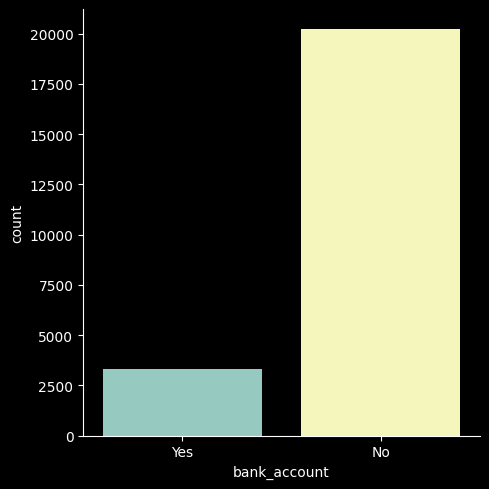

In [6]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [7]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


### 2. Understand the dataset

In [8]:
#show some information about the dataset
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [9]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


### 3. Data preparation for machine learning

In [61]:
# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [63]:
MMS = MinMaxScaler(feature_range=(0, 1))
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [74]:
# function to preprocess our data from train models
def preprocessing_data(data, scaler):

    # Convert the following numerical labels from interger to float
    float_array = data[['household_size',
                        'age_of_respondent', 'year']].values.astype(float)

    # categorical features to be onverted to One Hot Encoding
    categ = ['relationship_with_head',
             'marital_status',
             'education_level',
             'job_type',
             'country']

    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep='_', columns=categ)

    # Label Encoder conversion
    data['location_type'] = le.fit_transform(data['location_type'])
    data['cellphone_access'] = le.fit_transform(data['cellphone_access'])
    data['gender_of_respondent'] = le.fit_transform(
        data['gender_of_respondent'])
    
    # drop uniquid column
    data = data.drop(['uniqueid'], axis=1)
    # scale our data
    data = scaler.fit_transform(data)

    return data


Preprocess both train and test dataset.

In [189]:
# preprocess the train data 
scaler = MMS
processed_train = preprocessing_data(X_train, scaler)
processed_test = preprocessing_data(test, scaler)

Observe the first row in the train data.

In [190]:
# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


Observe the shape of the train data.

In [191]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


### 4. Model Building and Experiments

In [193]:
X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, test_size = 0.1, random_state=42)

Only 10% of the train dataset will be used for evaluating the models. The parameter stratify = y_train will ensure an equal balance of values from both classes (‘yes’ and ‘no’) for both train and validation set.

In [194]:
# create models
xg_model = XGBClassifier()
lgbm_model = LGBMClassifier()

In [195]:
#fitting the models
xg_model.fit(X_Train,y_Train)

lgbm_model.fit(X_Train,y_Train)

LGBMClassifier()

The evaluation metric for this challenge will be the percentage of survey respondents for whom you predict the binary 'bank account' classification incorrectly.

This means the **lower** the incorrect percentage we get, the better the model performance.

In [197]:
# evaluate the model
xg_y_model = xg_model.predict(X_Val)
lgbm_y_model = lgbm_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, lgbm_y_model))

Error rate of XGB classifier:  0.10752231194220141


Let’s check the confusion matrix for model.

In [198]:
model = lgbm_model

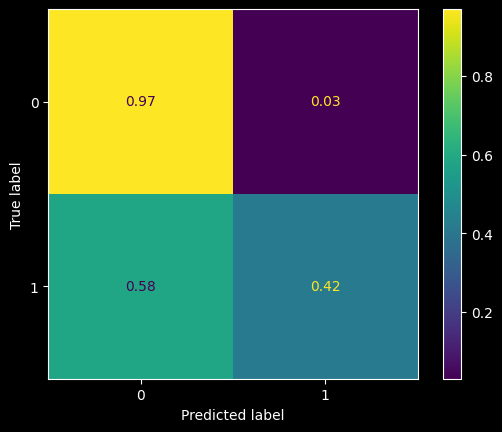

In [199]:
ConfusionMatrixDisplay.from_estimator(model, X_Val, y_val, normalize='true')
plt.show()

In [84]:
# Optimize model parameters
param_grid = {
    'max_depth': (3, 5),
    'learning_rate': (0.1, 0.01),
    'n_estimators': (100, 150),
    'subsample': (0.6, 0.8, 1.0)
}
my_lgbm_model = GridSearchCV(model, param_grid, n_jobs=-1, verbose=2, cv=5)
display(
    my_lgbm_model.fit(X_Train, y_Train),
    my_lgbm_model.best_params_
)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': (0.1, 0.01), 'max_depth': (3, 5),
                         'n_estimators': (100, 150),
                         'subsample': (0.6, 0.8, 1.0)},
             verbose=2)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

In [123]:
# fit by setting best parameters and Evaluate model
lgbm_model = LGBMClassifier(
    learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6)

lgbm_model.fit(X_Train, y_Train)
y_pred = lgbm_model.predict(X_Val)

# Get error rate
print("Error rate of the lgbm classifier: ", 1 - accuracy_score(y_val, y_pred))

Error rate of the lgbm classifier:  0.1079473013174671


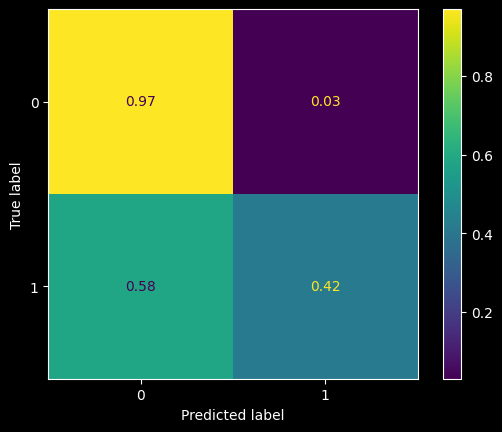

In [202]:
ConfusionMatrixDisplay.from_estimator(lgbm_model, X_Val, y_val, normalize='true')

### 5. Making the first submission

In [203]:
# Get the predicted result for the test Data
test.bank_account = lgbm_model.predict(processed_test)

Then we create a submission file according to the instruction provided in the SubmissionFile.csv.


In [204]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

Let’s observe the sample results from our submission DataFrame.


In [206]:
#show the five sample
submission

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0


Save results in the CSV file.


In [207]:
# Create submission csv file csv file
submission.to_csv(
    f'submissions/soumission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)
